In [1]:
using Pkg

# Activate local project environment
Pkg.activate(expanduser("/g/data/v46/txs156/ocean-ensembles/analysis/"))

# Pkg.precompile()

using CairoMakie, JLD2  # From global
using Oceananigans  # From local

  Activating project at `/g/data/v46/txs156/ocean-ensembles/analysis`
Precompiling packages...
  49349.9 ms  ✓ CairoMakie
  1 dependency successfully precompiled in 59 seconds. 239 already precompiled.
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
[ Info: Precompiling Oceananigans [9e8cae18-63c1-5223-a75c-80ca9d6e9a09]
Precompiling packages...
   8319.0 ms  ✓ TaylorSeries → TaylorSeriesIAExt
  1 dependency successfully precompiled in 9 seconds. 14 already precompiled.
[ Info: Precompiling TaylorSeriesIAExt [ed7ef945-33a4-511e-97fe-2b89c7a130ca]
┌ Warning: Module IntervalArithmetic with build ID fafbfcfd-4e65-8699-0006-21d99a6e5cee is missing from the cache.
│ This may mean IntervalArithmetic [d1acc4aa-44c8-5952-acd4-ba5d80a2a253] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2018
[ Info: Skipping precompilation since __precompile__(false). Importing TaylorSeriesIAExt [ed7ef945-33a4-511e-97fe-2b89c7a130ca].
Precompili

In [2]:
experiment_path = expanduser("/g/data/v46/txs156/ocean-ensembles/experiments/")
figdir = expanduser("/g/data/v46/txs156/ocean-ensembles/figures/")
output_path = expanduser("/g/data/v46/txs156/ocean-ensembles/outputs/")

"/g/data/v46/txs156/ocean-ensembles/outputs/"

In [3]:
variables_basins = ["_global_", "_atl_", "_ipac_"]
variables_diags = ["zonal", "depth", "tot"]
variables_tracers = ["T", "S", "dV"]
variables_velocities =  ["u", "v", "w"]
variables_vel_volumes = ["dV_u", "dV_v", "dV_w"]
# variables_fluxes = ["latent_heat", "sensible_heat", "water_vapor", "x_momentum", "y_momentum"]

tracercontent_vars = vec([tracer * basin * diag for tracer in variables_tracers,
                         basin in variables_basins,
                         diag in variables_diags])

transport_vars = vcat(
    vec([velocity * basin * diag for velocity in variables_velocities,
                                 basin in variables_basins,
                                 diag in variables_diags]),
    vec([volume * basin * diag for volume in variables_vel_volumes,
                               basin in variables_basins,
                               diag in variables_diags])
)

function create_dict(vars, path)
    dicts = Dict()
    for var in vars
        try
            # Surface
            dicts[var] = FieldTimeSeries(path, var)
        catch e
            if e isa KeyError
                @warn "Skipping variable $var: Key not found in file."
            else
                rethrow(e)
            end
        end
    end
    return dicts
end

@info "I am loading the otc" 
OTC = create_dict(tracercontent_vars, output_path * "ocean_tracer_content_onedeg_iteration0_rank0.jld2")

@info "I am loading the mass transport" 
masstrans = create_dict(transport_vars, output_path * "mass_transport_onedeg_iteration0_rank0.jld2")

# @info "I am loading the fluxes" 
# fluxes = create_dict(variables_fluxes, output_path * "fluxes_RYF1deg.jld2")

@info "I am loading the surface" 
surface = create_dict(vcat(variables_tracers, variables_velocities), output_path * "global_surface_fields_onedeg_iteration0_rank0.jld2")


[ Info: I am loading the otc
[ Info: I am loading the mass transport
[ Info: I am loading the surface
┌ Warning: Skipping variable dV: Key not found in file.
└ @ Main In[3]:29


Dict{Any, Any} with 5 entries:
  "v" => 360×180×1×15 FieldTimeSeries{InMemory} located at (Center, Face, Cente…
  "S" => 360×180×1×15 FieldTimeSeries{InMemory} located at (Center, Center, Cen…
  "w" => 360×180×1×15 FieldTimeSeries{InMemory} located at (Center, Center, Fac…
  "T" => 360×180×1×15 FieldTimeSeries{InMemory} located at (Center, Center, Cen…
  "u" => 360×180×1×15 FieldTimeSeries{InMemory} located at (Face, Center, Cente…

In [48]:
times = surface["T"].times

mxtemp = zeros(length(times)-2)  # Ensure the array is 1D with the correct size
mntemp = zeros(length(times)-2)  # Ensure the array is 1D with the correct size
mxw = zeros(length(times)-2)  # Ensure the array is 1D with the correct size
mnw = zeros(length(times)-2)  # Ensure the array is 1D with the correct size
mxu = zeros(length(times)-2)  # Ensure the array is 1D with the correct size
mnu = zeros(length(times)-2)  # Ensure the array is 1D with the correct size
mxv = zeros(length(times)-2)  # Ensure the array is 1D with the correct size
mnv = zeros(length(times)-2)  # Ensure the array is 1D with the correct size

for time_step in eachindex(times[1:end-2])  # Proper way to iterate over indices
    mxtemp[time_step] = maximum(filter(!isnan, surface["T"][time_step]))  # Ignore NaNs
    mntemp[time_step] = minimum(filter(!isnan, surface["T"][time_step]))  # Ignore NaNs
    mnw[time_step] = minimum(filter(!isnan, surface["w"][time_step]))  # Ignore NaNs
    mxw[time_step] = maximum(filter(!isnan, surface["w"][time_step]))  # Ignore NaNs
    mnu[time_step] = minimum(filter(!isnan, surface["u"][time_step]))  # Ignore NaNs
    mxu[time_step] = maximum(filter(!isnan, surface["u"][time_step]))  # Ignore NaNs
    mnv[time_step] = minimum(filter(!isnan, surface["v"][time_step]))  # Ignore NaNs
    mxv[time_step] = maximum(filter(!isnan, surface["v"][time_step]))  # Ignore NaNs

end

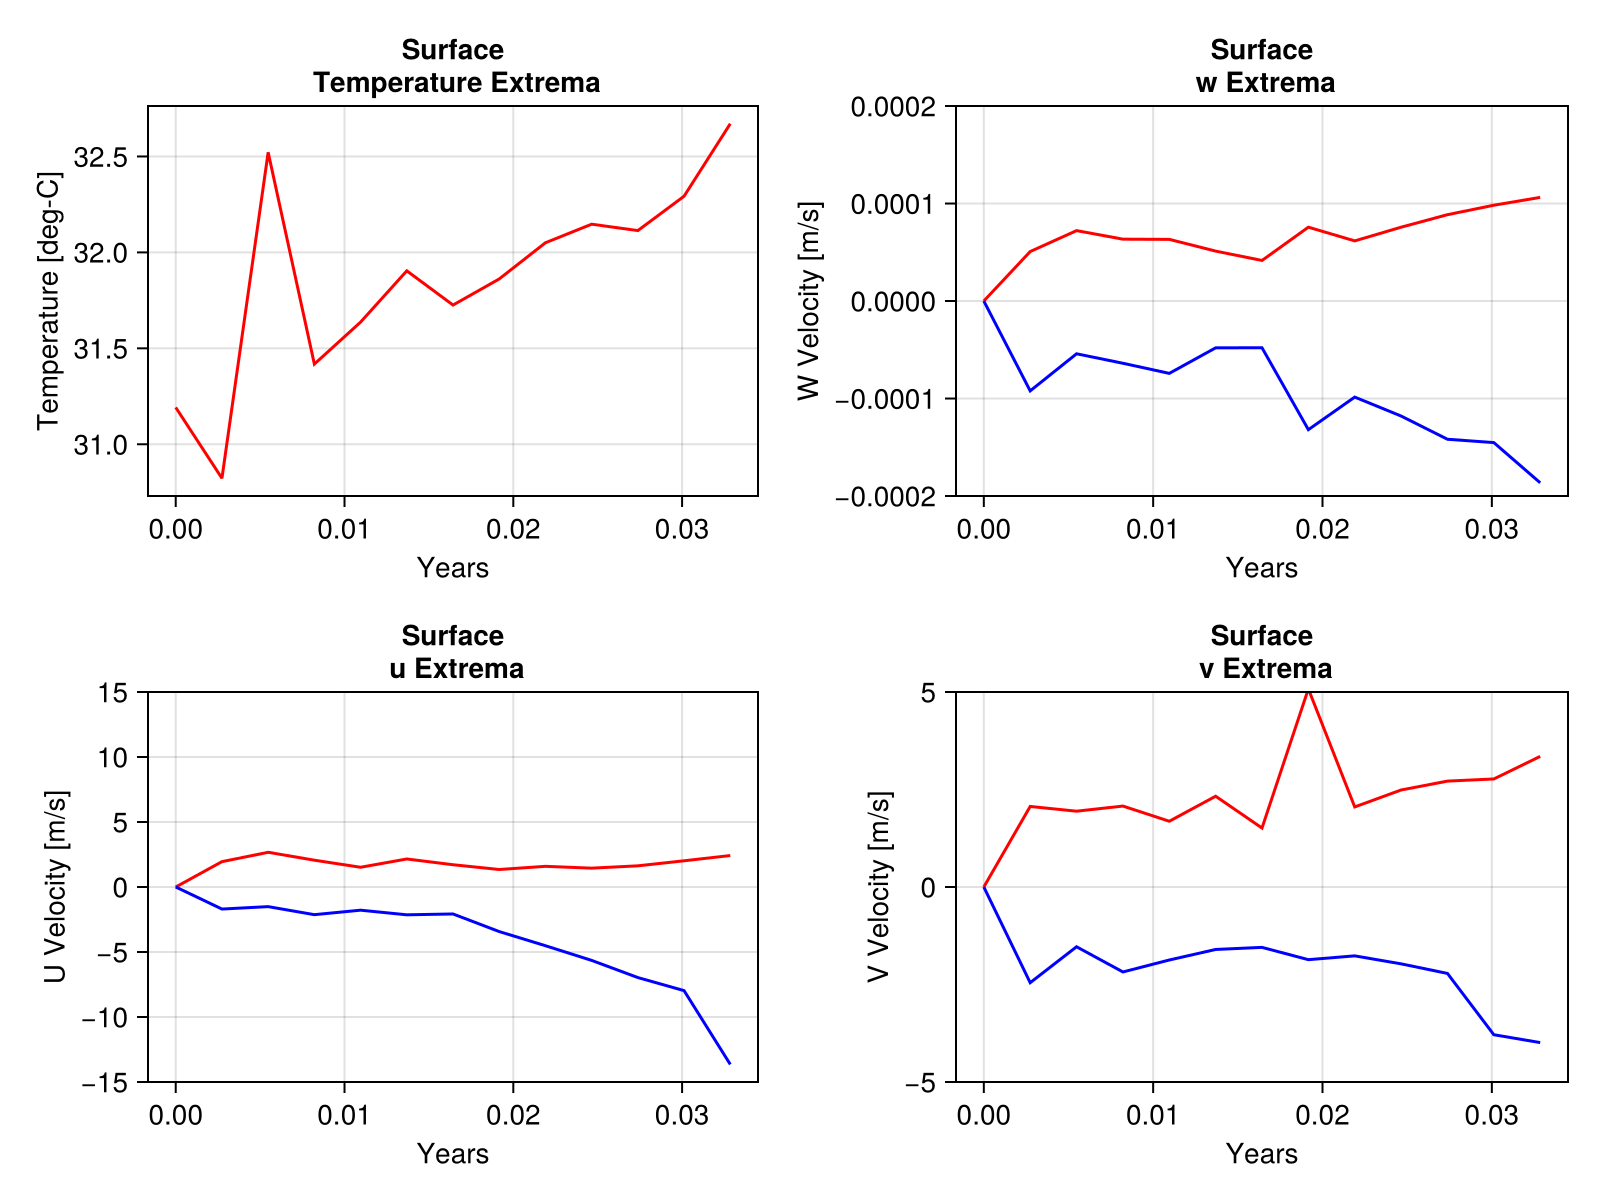

CairoMakie.Screen{IMAGE}


In [60]:
fig = Figure(size = (1600/2, 1200/2))
ax1 = Axis(fig[1, 1], xlabel="Years", ylabel="Temperature [deg-C]", title="Surface\n Temperature Extrema")
ax2 = Axis(fig[1,2], xlabel="Years", ylabel="W Velocity [m/s]", title="Surface\n w Extrema")
ax3 = Axis(fig[2, 1], xlabel="Years", ylabel="U Velocity [m/s]", title="Surface\n u Extrema")
ax4 = Axis(fig[2,2], xlabel="Years", ylabel="V Velocity [m/s]", title="Surface\n v Extrema")

lines!(ax1, times[1:end-2]/(3600*24*365.25), mxtemp, color = :red)
lines!(ax2, times[1:end-2]/(3600*24*365.25), mxw, color = :red)
lines!(ax2, times[1:end-2]/(3600*24*365.25), mnw, color = :blue)
ylims!(ax2, -2e-4, 2e-4)
lines!(ax3, times[1:end-2]/(3600*24*365.25), mxu, color = :red)
lines!(ax3, times[1:end-2]/(3600*24*365.25), mnu, color = :blue)
ylims!(ax3, -15, 15)
lines!(ax4, times[1:end-2]/(3600*24*365.25), mxv, color = :red)
lines!(ax4, times[1:end-2]/(3600*24*365.25), mnv, color = :blue)
ylims!(ax4, -5, 5)
save(figdir*"surface_extrema_1dg.png", fig)
display(fig)

In [ ]:
1.7268001022703722e19

In [128]:
for key in keys(OTC)
        if occursin("T", String(key))
        @show key
        @show sum(filter(!isnan, OTC[key]))
        @show maximum(filter(!isnan, OTC[key]))
        @show minimum(filter(!isnan, OTC[key]))
    end
end

key = "T_global_zonal"
sum(filter(!isnan, OTC[key])) = 6.143767041229796e19
maximum(filter(!isnan, OTC[key])) = 1.068161856176128e15
minimum(filter(!isnan, OTC[key])) = -1.02791209025536e14
key = "T_ipac_tot"
sum(filter(!isnan, OTC[key])) = 4.4740056946653e19
maximum(filter(!isnan, OTC[key])) = 3.443752606688608e18
minimum(filter(!isnan, OTC[key])) = 3.439375176020525e18
key = "T_atl_depth"
sum(filter(!isnan, OTC[key])) = 1.6697869172486439e19
maximum(filter(!isnan, OTC[key])) = 2.849676655905997e16
minimum(filter(!isnan, OTC[key])) = 4.6431247269888e14
key = "T_ipac_zonal"
sum(filter(!isnan, OTC[key])) = 4.473989849841007e19
maximum(filter(!isnan, OTC[key])) = 8.68974761869312e14
minimum(filter(!isnan, OTC[key])) = -4.8023623172096e13
key = "T_atl_tot"
sum(filter(!isnan, OTC[key])) = 1.6697869124906254e19
maximum(filter(!isnan, OTC[key])) = 1.284649182367318e18
minimum(filter(!isnan, OTC[key])) = 1.284233979288879e18
key = "T_ipac_depth"
sum(filter(!isnan, OTC[key])) = 4.4740057352527

In [180]:
times = surface["T"].times
depth = (masstrans["w_global_depth"].grid.underlying_grid.z.cᵃᵃᶠ.parent)[5:80]
# masstrans_w = zeros(length(times)-2, size(masstrans["w_global_depth"])[3])  # Ensure the array is 1D with the correct size
# masstrans_u = zeros(length(times)-2, size(masstrans["u_global_depth"])[3])  # Ensure the array is 1D with the correct size
# masstrans_v = zeros(length(times)-2, size(masstrans["v_global_depth"])[3])  # Ensure the array is 1D with the correct size
otc_T_global_depth = zeros(length(times)-2, size(OTC["T_global_depth"])[3])  # Ensure the array is 1D with the correct size
otc_OHC_global_depth = zeros(length(times)-2, size(OTC["T_global_depth"])[3])  # Ensure the array is 1D with the correct size
otc_S_global_depth = zeros(length(times)-2, size(OTC["S_global_depth"])[3])  # Ensure the array is 1D with the correct size
otc_FW_global_depth = zeros(length(times)-2, size(OTC["S_global_depth"])[3])  # Ensure the array is 1D with the correct size

for time_step in eachindex(times[1:end-2])  # Proper way to iterate over indices
    otc_OHC_global_depth[time_step, :] = interior(OTC["T_global_depth"][time_step], 1, 1, :, 1)*4000*1025
    otc_FW_global_depth[time_step, :] = interior(OTC["S_global_depth"][time_step], 1, 1, :, 1)/35
    otc_T_global_depth[time_step, :] = interior(OTC["T_global_depth"][time_step], 1, 1, :, 1)./
                                interior(OTC["dV_global_depth"][time_step], 1, 1, :, 1)# Ignore NaNs
    otc_S_global_depth[time_step, :] = interior(OTC["S_global_depth"][time_step], 1, 1, :, 1)./
                                interior(OTC["dV_global_depth"][time_step], 1, 1, :, 1)# Ignore NaNs
end

In [179]:
@show 4.30577082237662e18 + 1.2962229509989335e19 - 1.7268000675963339e19
@show 4.30577083418778e18 + 1.2962229636556653e19 - 1.7268000449873576e19
@show 4.3057679362687263e18 + 1.2962233085299663e19 - 1.7268001022703722e19


(4.30577082237662e18 + 1.2962229509989335e19) - 1.7268000675963339e19 = -3.4359738368e11
(4.30577083418778e18 + 1.2962229636556653e19) - 1.7268000449873576e19 = 2.0870856704e10
(4.3057679362687263e18 + 1.2962233085299663e19) - 1.7268001022703722e19 = -1.135333376e9


-1.135333376e9

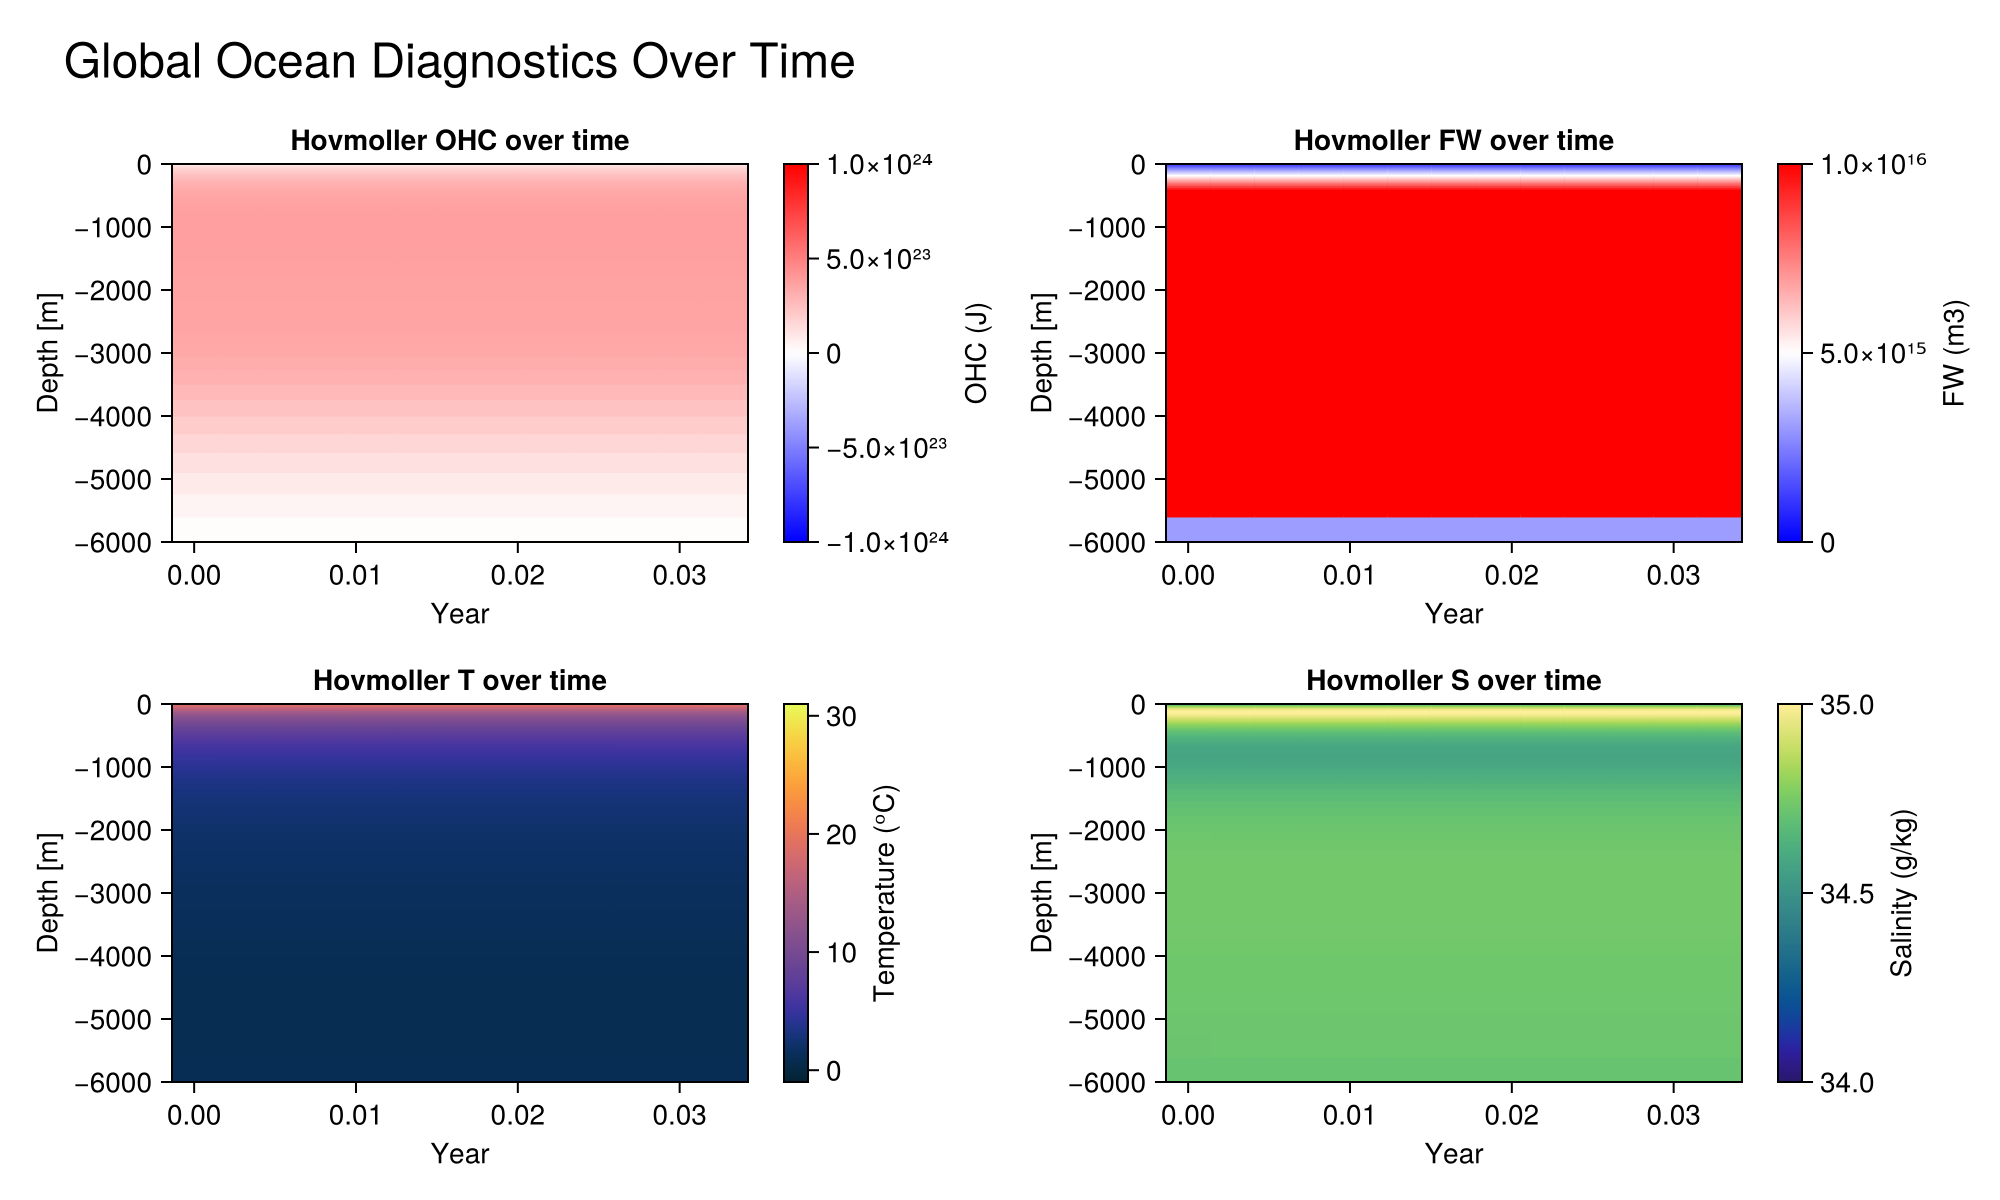

CairoMakie.Screen{IMAGE}


In [181]:

fig = Figure(size = (2000/2, 1200/2))

Label(fig[0, :], "Global Ocean Diagnostics Over Time";
      fontsize = 24,       halign = :center,
      tellwidth = false)
ax1 = Axis(fig[1, 1],         title = "Hovmoller OHC over time",
         xlabel = "Year",
         ylabel = "Depth [m]")
ax2 = Axis(fig[2, 1],         title = "Hovmoller T over time",
         xlabel = "Year",
         ylabel = "Depth [m]")
ax3 = Axis(fig[1, 3],         title = "Hovmoller FW over time",
         xlabel = "Year",
         ylabel = "Depth [m]")
ax4 = Axis(fig[2, 3],         title = "Hovmoller S over time",
         xlabel = "Year",
         ylabel = "Depth [m]")

hm1 = heatmap!(ax1, times[1:end-2]/(3600*24*365.25),  depth, otc_OHC_global_depth, colorrange = (-1e24, 1e24), nan_color=:lightgray,
         colormap = :bwr)
Colorbar(fig[1, 2], hm1, label = "OHC (J)")
hm2 = heatmap!(ax2, times[1:end-2]/(3600*24*365.25),  depth, otc_T_global_depth, colorrange = (-1,31), nan_color=:lightgray,
         colormap = :thermal)
Colorbar(fig[2, 2], hm2, label = "Temperature (ᵒC)")

hm3 = heatmap!(ax3, times[1:end-2]/(3600*24*365.25),  depth, otc_FW_global_depth, colorrange = (0, 1e16), nan_color=:lightgray,
         colormap = :bwr)
Colorbar(fig[1, 4], hm3, label = "FW (m3)")
hm4 = heatmap!(ax4, times[1:end-2]/(3600*24*365.25),  depth, otc_S_global_depth, colorrange = (34,35), nan_color=:lightgray,
         colormap = :haline)
Colorbar(fig[2, 4], hm4, label = "Salinity (g/kg)")


display(fig)

In [194]:
vec(view(OTC["T_global_tot"], 1, 1, 1, :))

15-element view(::FieldTimeSeries{Nothing, Nothing, Nothing, Oceananigans.OutputReaders.Linear, InMemory{Nothing}, Tuple{Colon, Colon, Colon}, OffsetArrays.OffsetArray{Float64, 4, Array{Float64, 4}}, ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, Oceananigans.Grids.MutableVerticalDiscretization{OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}}, Oceananigans.Orthogo

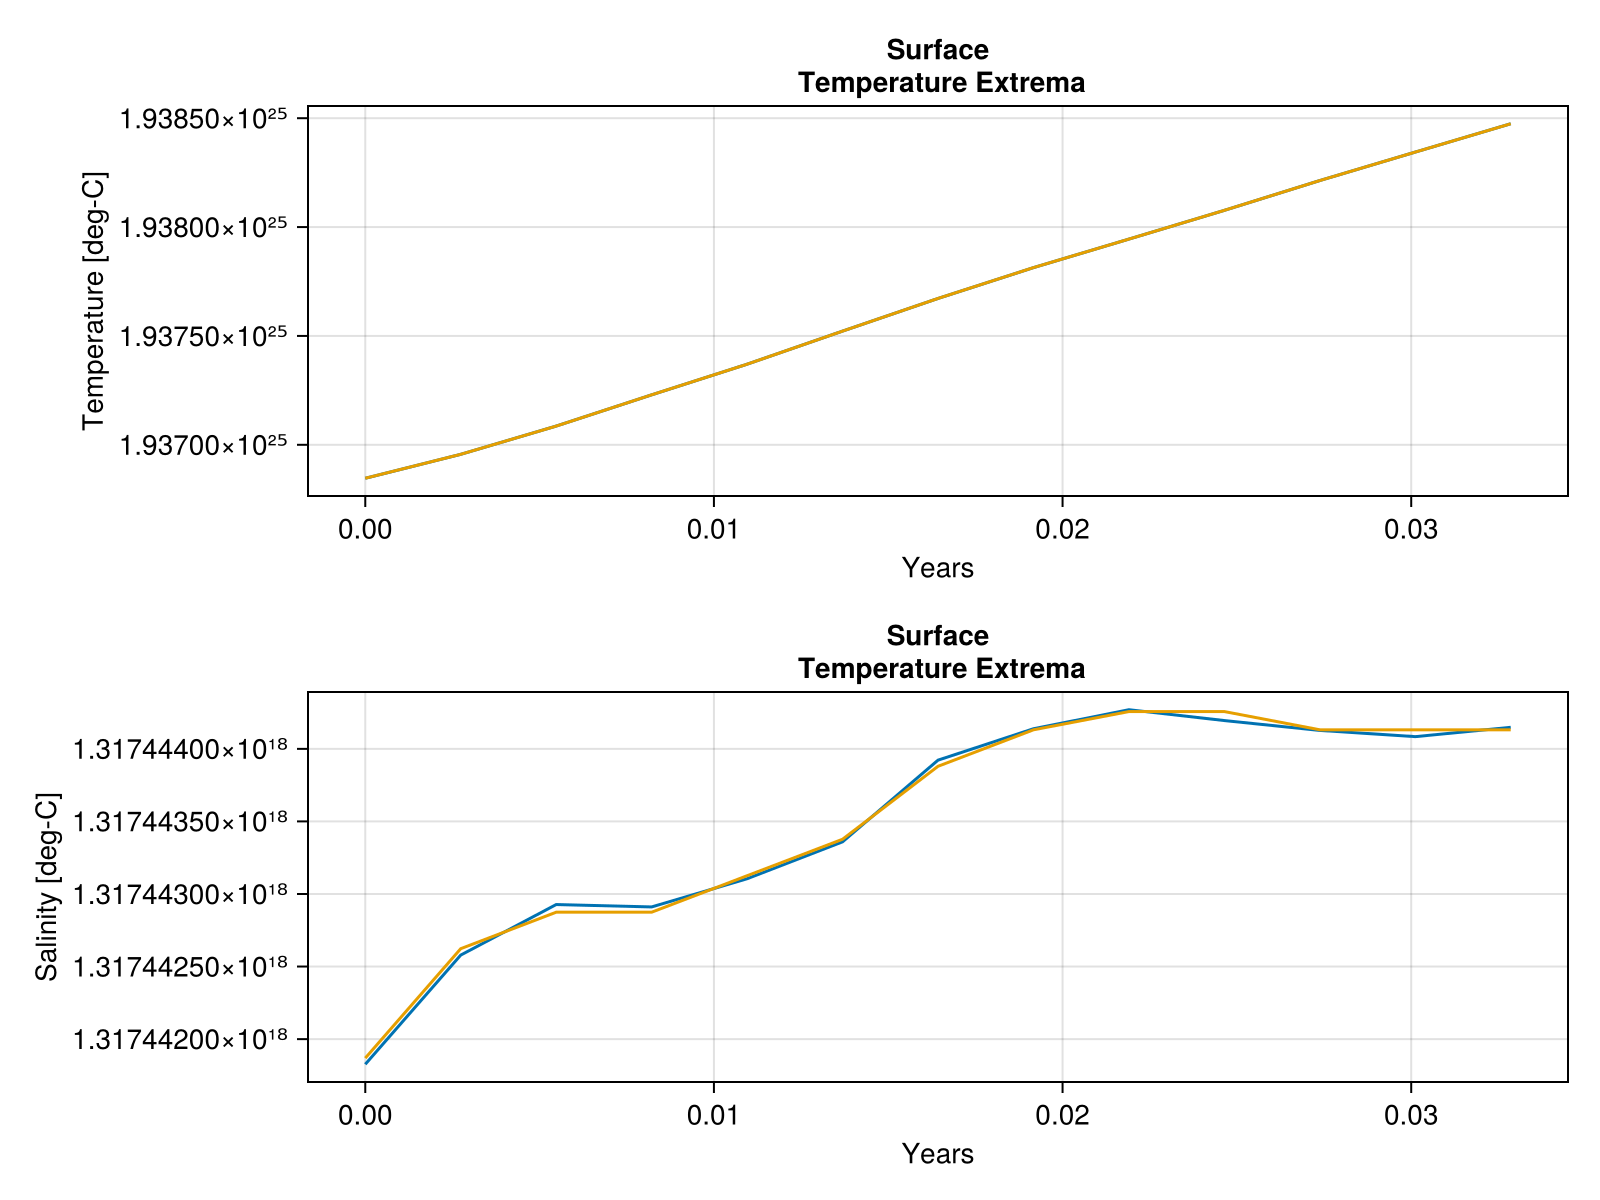

CairoMakie.Screen{IMAGE}


In [201]:
sum(otc_OHC_global_depth, dims=(2))
fig = Figure(size = (1600/2, 1200/2))
ax1 = Axis(fig[1, 1], xlabel="Years", ylabel="Temperature [deg-C]", title="Surface\n Temperature Extrema")
ax2 = Axis(fig[2, 1], xlabel="Years", ylabel="Salinity [deg-C]", title="Surface\n Temperature Extrema")

lines!(ax1, times[1:end-2]/(3600*24*365.25), vec(sum(otc_OHC_global_depth, dims=(2))))
lines!(ax1, times[1:end]/(3600*24*365.25), view(OTC["T_global_tot"], 1, 1, 1, :)*4000*1025)
lines!(ax2, times[1:end-2]/(3600*24*365.25), vec(sum(otc_FW_global_depth, dims=(2))))
lines!(ax2, times[1:end]/(3600*24*365.25), view(OTC["S_global_tot"], 1, 1, 1, :)/35)

display(fig)

In [46]:
fig = Figure(size = (1600/2, 1200/2))
ax1 = Axis(fig[1, 1], xlabel="Years", ylabel="Temperature [deg-C]", title="Surface\n Temperature Extrema")
ax2 = Axis(fig[1,2], xlabel="Years", ylabel="W Velocity [m/s]", title="Surface\n w Extrema")
ax3 = Axis(fig[2, 1], xlabel="Years", ylabel="U Velocity [m/s]", title="Surface\n u Extrema")
ax4 = Axis(fig[2,2], xlabel="Years", ylabel="V Velocity [m/s]", title="Surface\n v Extrema")

lines!(ax1, times[1:end-2]/(3600*24*365.25), 
    , color = :red)
lines!(ax2, times[1:end-2]/(3600*24*365.25), mxw, color = :red)
lines!(ax2, times[1:end-2]/(3600*24*365.25), mnw, color = :blue)
ylims!(ax2, -2e-4, 2e-4)
lines!(ax3, times[1:end-2]/(3600*24*365.25), mxu, color = :red)
lines!(ax3, times[1:end-2]/(3600*24*365.25), mnu, color = :blue)
ylims!(ax3, -15, 15)
lines!(ax4, times[1:end-2]/(3600*24*365.25), mxv, color = :red)
lines!(ax4, times[1:end-2]/(3600*24*365.25), mnv, color = :blue)
ylims!(ax4, -5, 5)
# save(figdir*"surface_extrema_1dg.png", fig)
display(fig)

-0.007991169903626931

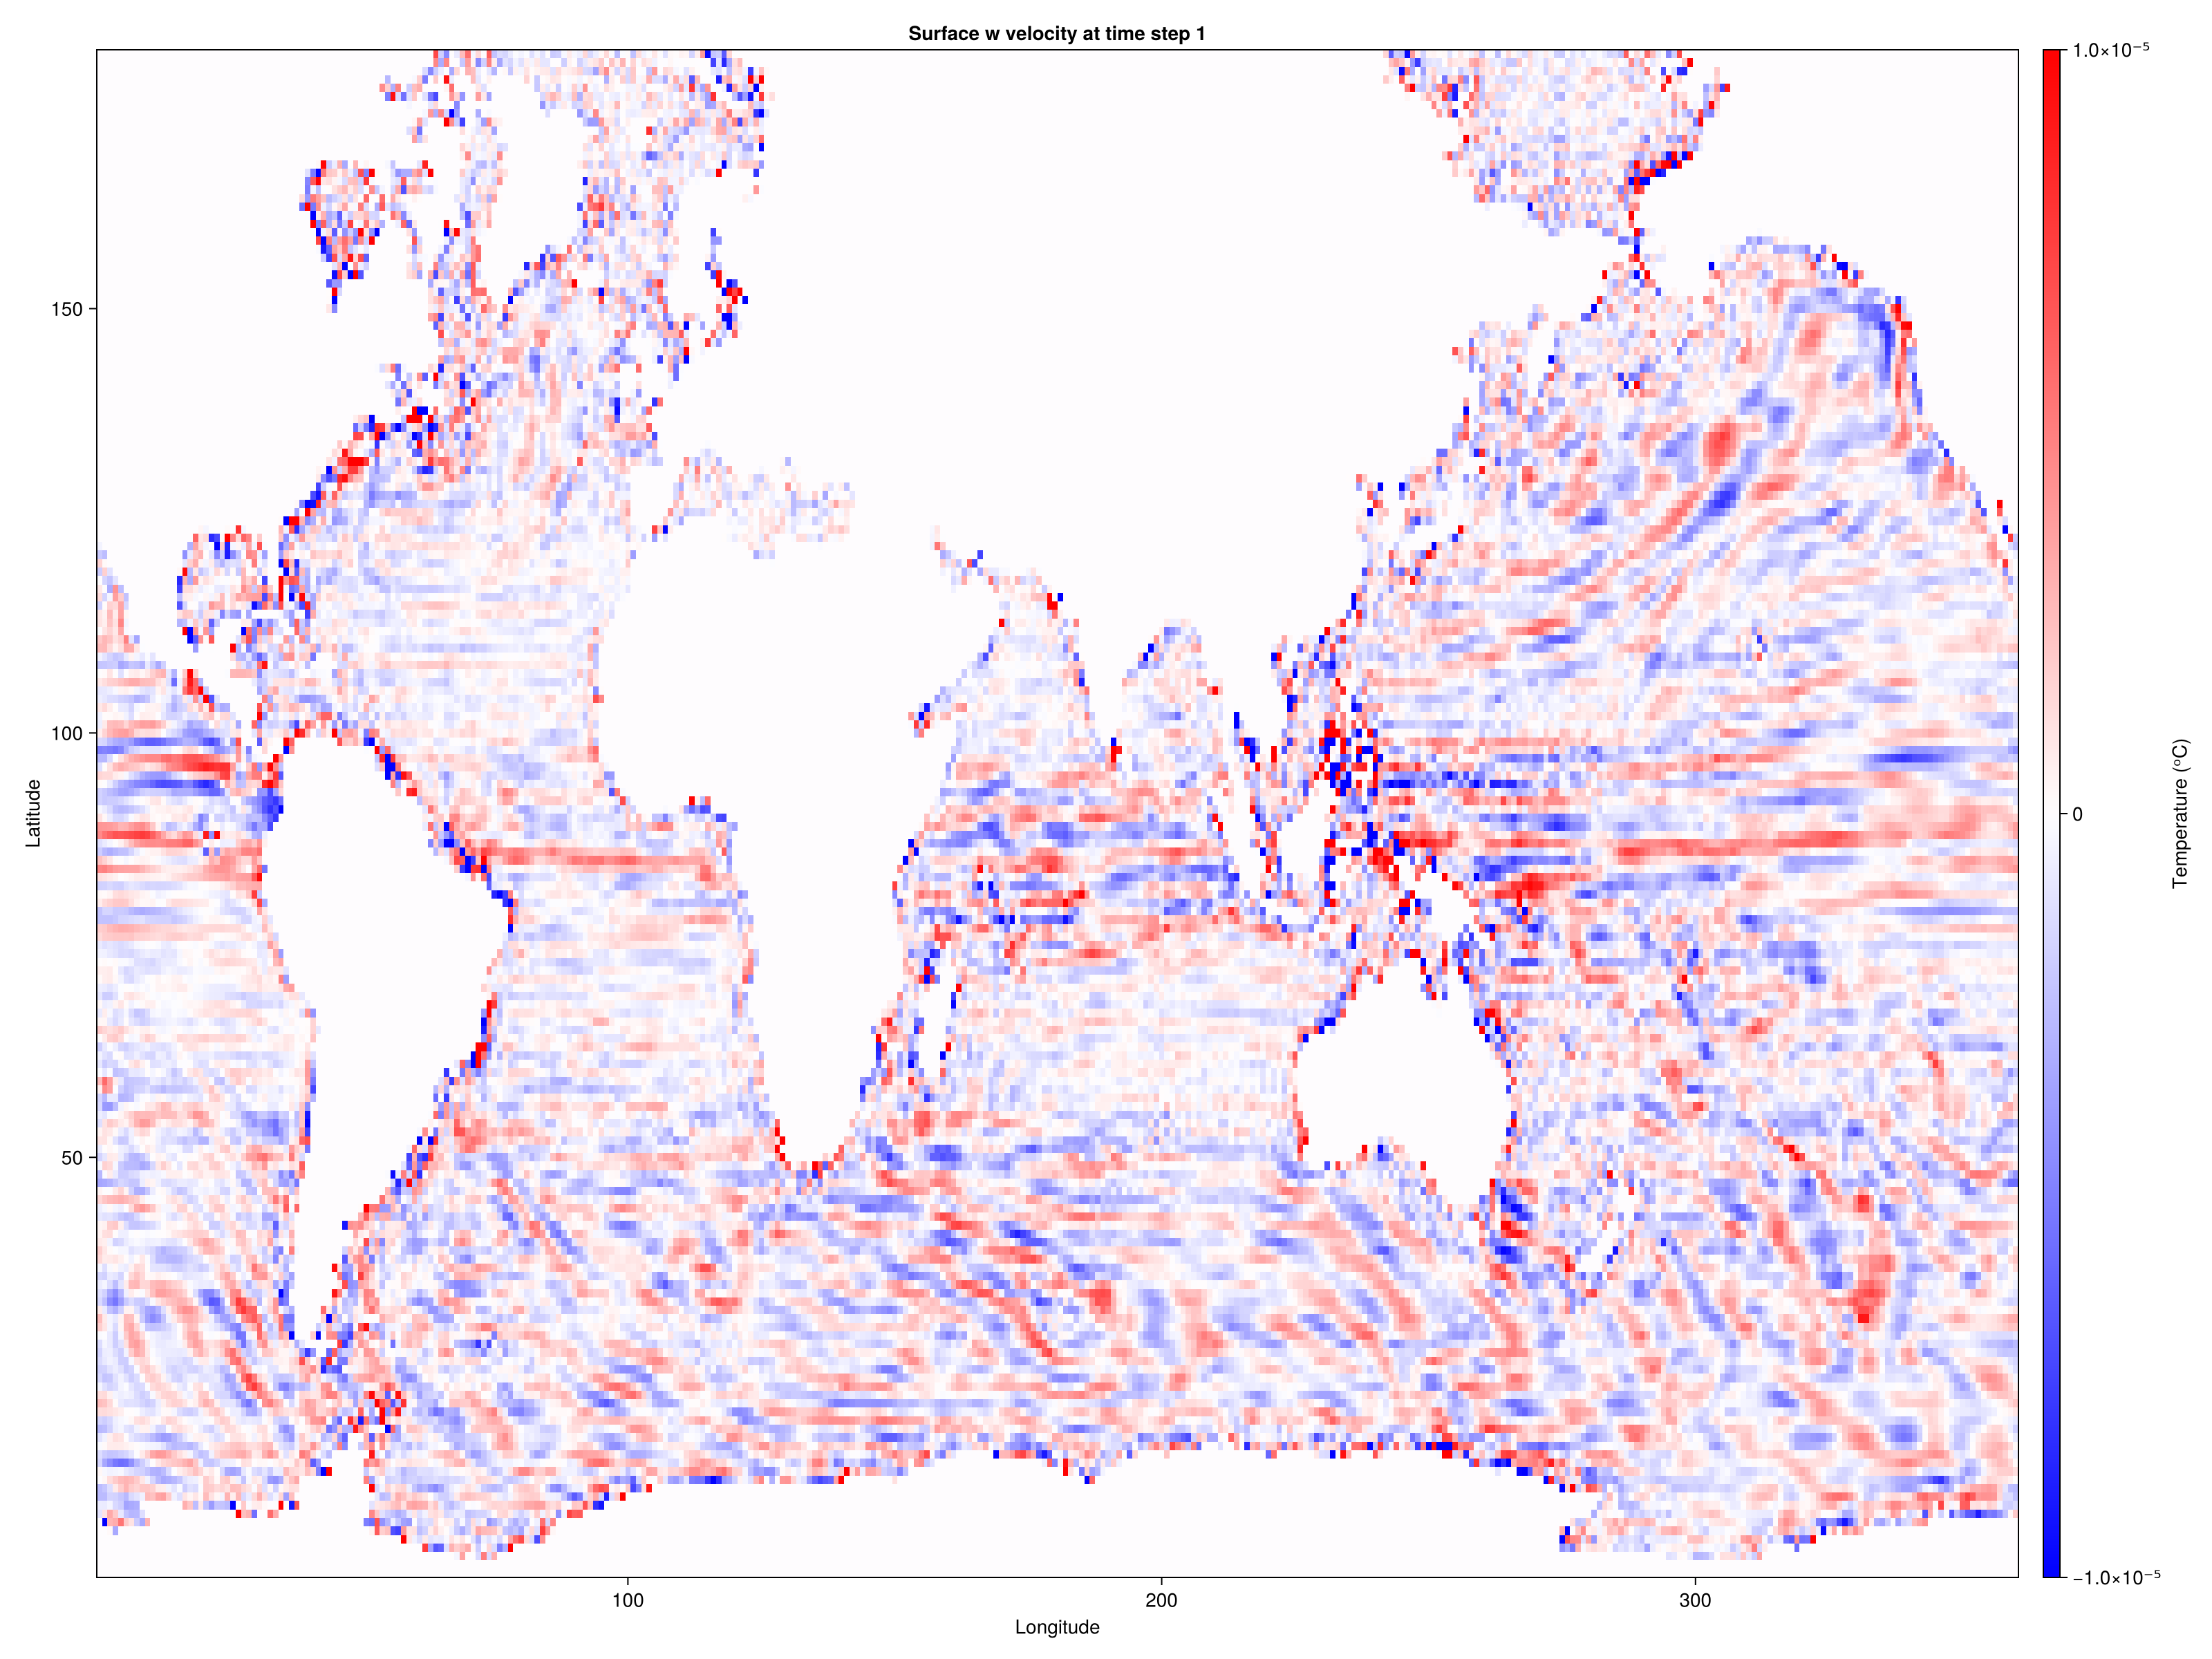

CairoMakie.Screen{IMAGE}


In [26]:
fig = Figure(size = (1600, 1200))
ax1 = Axis(fig[1, 1],         title = "Surface w velocity at time step 1",
         xlabel = "Longitude",
         ylabel = "Latitude")
time_slice = 13
hm = heatmap!(ax1, view(interior(surface["w"][time_slice]), :, :, 1), colorrange = (-1e-5, 1e-5), nan_color=:lightgray,
         colormap = :bwr)
Colorbar(fig[1, 2], hm, label = "Temperature (ᵒC)")

display(fig)